In [64]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

In [65]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set

def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

def build_model(window_size, feature_count):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

symbol = "AAPL"
company_df = pd.read_csv(f'../data/{symbol}/{symbol}_2024-06-24.csv')

market_df = pd.read_csv(f'../data/market_data/market_data_2024-06-24.csv')
market_df['Date'] = pd.to_datetime(market_df['Date'])
company_df['timestamp'] = pd.to_datetime(company_df['timestamp'])
df = pd.merge(market_df, company_df, left_on='Date', right_on='timestamp', how='inner')

training_set, testing_set = split_data(df, 0.8, [
    'Value_interest', 'Value_inflation', 'Value_gdp',
    'Value_unemployment', 'Value_cci', 'Open_sp500', 'High_sp500',
    'Low_sp500', 'Close_sp500', 'Volume_sp500', 'Open_nasdaq',
    'High_nasdaq', 'Low_nasdaq', 'Close_nasdaq', 'Volume_nasdaq',
    'Open_dow_jones', 'High_dow_jones', 'Low_dow_jones', 'Close_dow_jones',
    'Volume_dow_jones', 'Open_tech_sector', 'High_tech_sector',
    'Low_tech_sector', 'Close_tech_sector', 'Volume_tech_sector',
    'open', 'high', 'low', 'close', 'volume'
    ])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)


X_train, y_train = get_x_y(training_set, 14, 28, 30)      # Change this line if you added more features
val_split_row = int(X_train.shape[0]*0.8)               # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print(training_set)
print(y_train)

training_set:  (4924, 30)
testing_set:  (1231, 30)
X_train:  (3928, 14, 30)
y_train:  (3928,)
X_val:  (982, 14, 30)
y_val:  (982,)
[[0.86531365 0.         0.         ... 0.09412535 0.09361665 0.00945048]
 [0.86162362 0.         0.         ... 0.094038   0.09743389 0.01515476]
 [0.85608856 0.         0.         ... 0.09941035 0.09924816 0.01180887]
 ...
 [0.12730627 1.         1.         ... 0.27742593 0.27610381 0.07097895]
 [0.12361624 1.         1.         ... 0.27805198 0.27945659 0.09467246]
 [0.12546125 1.         1.         ... 0.27610104 0.27500073 0.10710055]]
[0.11248512 0.11566373 0.11839241 ... 0.14567912 0.14821911 0.14808848]


In [66]:
window_size = 14        # Example window size
feature_count = 30       # Number of features (e.g., open, high, low, close, volume)
model = build_model(window_size, feature_count)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=300, batch_size=32, callbacks=[early_stopping, reduce_lr])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 14, 128)           81408     
                                                                 
 lstm_20 (LSTM)              (None, 14, 128)           131584    
                                                                 
 lstm_21 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 16)                2064      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 346,657
Trainable params: 346,657
Non-tr

In [67]:
# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, 14, 28, 30)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print(y_test)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

y_pred = model.predict(X_test)

full_test_set = np.zeros((len(y_test), feature_count))
full_test_set[:, 28] = y_test
y_test_inverse = scaler.inverse_transform(full_test_set)[:, 28]

full_pred_set = np.zeros((len(y_pred), feature_count))
full_pred_set[:, 28] = y_pred[:, 0]  # Ensure y_pred is 2D
y_pred_inverse = scaler.inverse_transform(full_pred_set)[:, 28]

print("Inverted (using stock prices)")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

print("Using MinMaxScaler")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# model.save_weights(f'weights/{symbol}_model2.weights.h5')

X_test:  (1217, 14, 30)
y_test:  (1217,)
[0.23581716 0.23453976 0.25580463 ... 0.25758297 0.25209768 0.25372574]
39/39 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0237
Test Loss: [0.0014686177019029856, 0.023712653666734695]
39/39 [==============================] - 1s 5ms/step
Inverted (using stock prices)
Mean Absolute Error (MAE): 9.467277516237635
Mean Squared Error (MSE): 234.09844258944423
Root Mean Squared Error (RMSE): 15.300275899128232
Using MinMaxScaler
Mean Absolute Error (MAE): 0.02371265501875426
Mean Squared Error (MSE): 0.0014686174183948964
Root Mean Squared Error (RMSE): 0.03832254451879333
Evaluate on test data
39/39 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0237
test loss, test acc: [0.0014686177019029856, 0.023712653666734695]


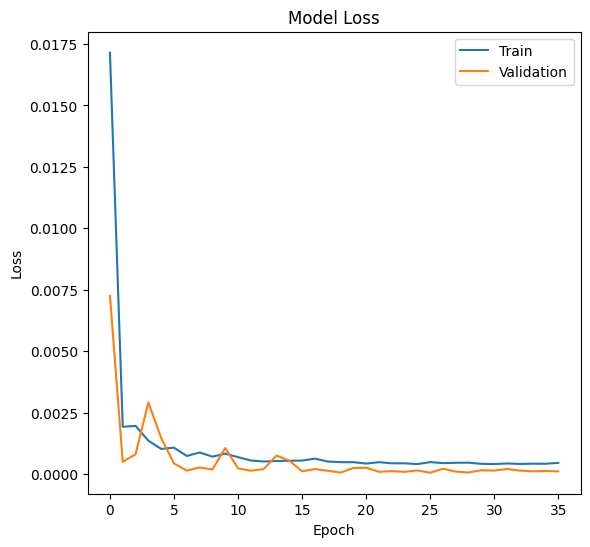

In [68]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [69]:
# Predict X_train and X_val
p_train = model.predict(X_train)
print(p_train.shape)
p_train

123/123 [==============================] - 1s 5ms/step
(3928, 1)


array([[0.11902183],
       [0.11917508],
       [0.11953955],
       ...,
       [0.15790218],
       [0.15683702],
       [0.15490562]], dtype=float32)

In [70]:
# # Predict X_train and X_val
# p_train = model.predict(X_train)
# p_train = scaler.inverse_transform(p_train)
# p_val = model.predict(X_val)
# p_val = scaler.inverse_transform(p_val)

# # Compare p_train and y_train
# plt.plot(p_train, color='red', label='prediction on training samples')
# plt.plot(scaler.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
# plt.xlabel('No. of Trading Days')
# plt.ylabel('Opening Value')
# plt.legend(loc='upper left')
# fig = plt.gcf()
# fig.set_size_inches(30,10)
# plt.show()

39/39 [==============================] - 0s 5ms/step
Inverted (using stock prices)
Mean Absolute Error (MAE): 0.2703242672137987
Mean Squared Error (MSE): 0.19086151969460083
Root Mean Squared Error (RMSE): 0.436877007514244
Using MinMaxScaler
Mean Absolute Error (MAE): 0.02371265501875426
Mean Squared Error (MSE): 0.0014686174183948964
Root Mean Squared Error (RMSE): 0.03832254451879333


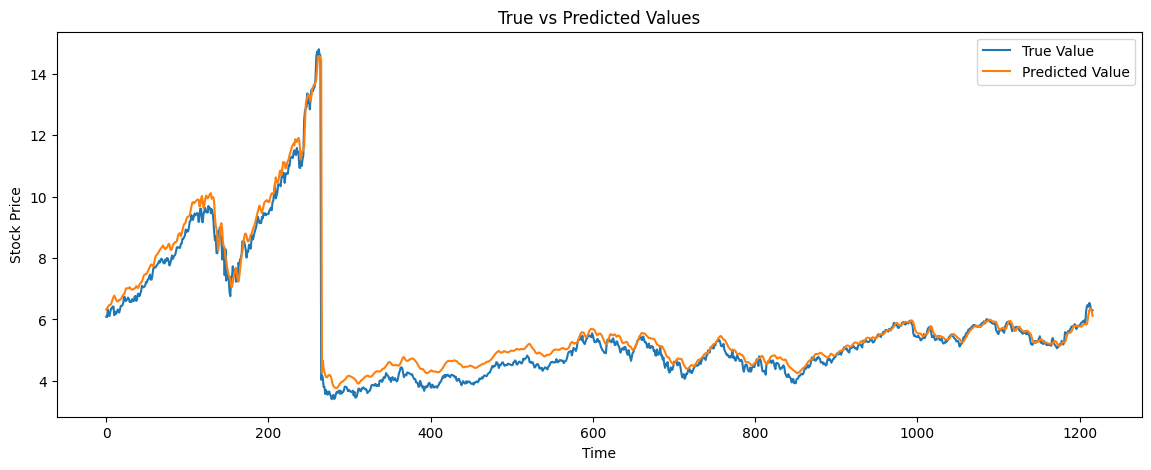

In [71]:
# Generate predictions
y_pred = model.predict(X_test)

full_test_set = np.zeros((len(y_test), feature_count))
full_test_set[:, 3] = y_test
y_test_inverse = scaler.inverse_transform(full_test_set)[:, 3]

full_pred_set = np.zeros((len(y_pred), feature_count))
full_pred_set[:, 3] = y_pred[:, 0]  # Ensure y_pred is 2D
y_pred_inverse = scaler.inverse_transform(full_pred_set)[:, 3]

print("Inverted (using stock prices)")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


print("Using MinMaxScaler")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_test_inverse, label='True Value')
plt.plot(y_pred_inverse, label='Predicted Value')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

39/39 [==============================] - 0s 5ms/step


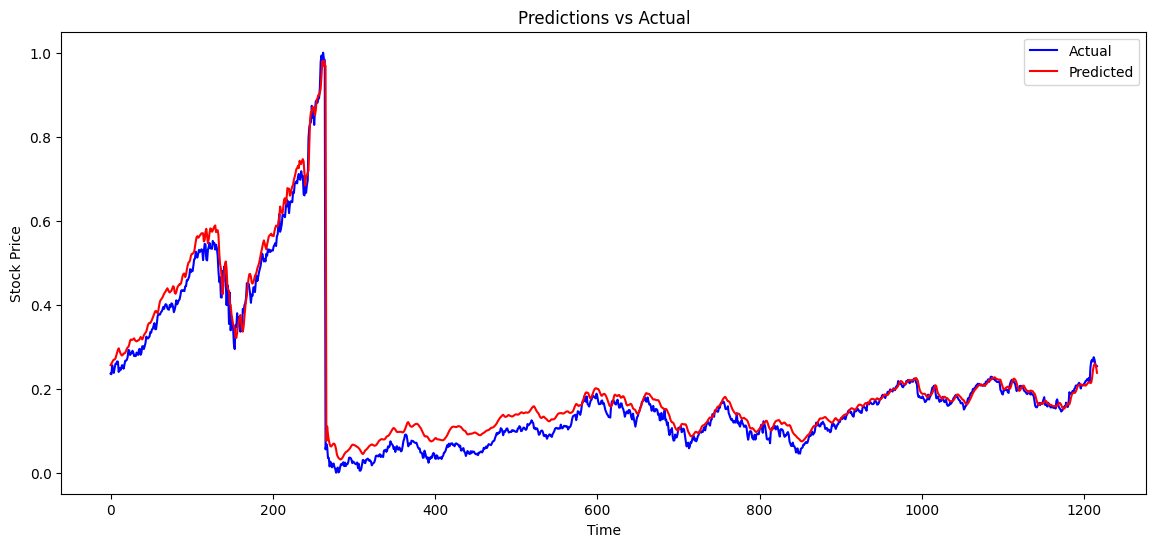

In [72]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual results
plt.figure(figsize=(14, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [73]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0237
test loss, test acc: [0.0014686177019029856, 0.023712653666734695]


In [74]:
# def backtest_strategy(predictions, actual_prices, initial_capital=10000, buy_threshold_percent=1.5, sell_threshold_percent=1.5, transaction_cost=0.001):
#     capital = initial_capital
#     position = 0
#     trades = []

#     for i in range(len(predictions) - 1):
#         current_price = actual_prices[i]
#         next_price_prediction = predictions[i + 1]
        
#         # Calculate percentage change
#         percent_increase = (next_price_prediction - current_price) / current_price * 100
#         percent_decrease = (current_price - next_price_prediction) / current_price * 100

#         # Define trade size factors based on percent change
#         if percent_increase >= buy_threshold_percent:
#             # Calculate trade size: Use a fraction of capital for buying
#             trade_size_fraction = 0.05  # Start with 5% of available capital
#             trade_size = capital * trade_size_fraction

#             if trade_size > 0:
#                 buy_price = current_price
#                 amount_to_buy = trade_size / buy_price
#                 capital_spent = buy_price * amount_to_buy * (1 + transaction_cost)
#                 capital -= capital_spent
#                 position += amount_to_buy
#                 trades.append(('Buy', i, buy_price, amount_to_buy, trade_size))
        
#         elif percent_decrease >= sell_threshold_percent:
#             if position > 0:
#                 trade_size_fraction = 0.05  # Start with 5% of current position value
#                 trade_size = position * trade_size_fraction

#                 sell_price = current_price
#                 capital_earned = trade_size * sell_price * (1 - transaction_cost)
#                 capital += capital_earned
#                 position -= trade_size / sell_price
#                 trades.append(('Sell', i, sell_price, trade_size, position))

#     # Calculate final capital
#     final_value = capital + (position * actual_prices[-1])
#     return final_value, trades


In [75]:
# # Example usage
# buy_threshold_percent = 1.5  # Percent increase threshold for buying
# sell_threshold_percent = 1.5  # Percent decrease threshold for selling

# final_value, trades = backtest_strategy(y_pred_inverse, y_test_inverse, buy_threshold_percent=buy_threshold_percent, sell_threshold_percent=sell_threshold_percent)
# print(f"Final Portfolio Value with Adjusted Strategy: ${final_value:.2f}")
# print(f"Trades Executed: {trades}")

In [76]:
# def backtest_strategy_random(predictions, actual_prices, initial_capital=10000, transaction_cost=0.001, trade_fraction=0.05):
#     capital = initial_capital
#     position = 0
#     trades = []

#     for i in range(len(predictions) - 1):
#         current_price = actual_prices[i]
#         next_price_prediction = predictions[i + 1]

#         # Randomly decide whether to buy, sell, or hold
#         action = random.choice(['buy', 'sell', 'hold'])

#         if action == 'buy':
#             # Calculate trade size: Use 5% of available capital
#             trade_size = capital * trade_fraction
#             if trade_size > 0:
#                 buy_price = current_price
#                 amount_to_buy = trade_size / buy_price
#                 capital_spent = buy_price * amount_to_buy * (1 + transaction_cost)
#                 capital -= capital_spent
#                 position += amount_to_buy
#                 trades.append(('Buy', i, buy_price, amount_to_buy, trade_size))

#         elif action == 'sell':
#             if position > 0:
#                 trade_size = position * trade_fraction
#                 sell_price = current_price
#                 capital_earned = trade_size * sell_price * (1 - transaction_cost)
#                 capital += capital_earned
#                 position -= trade_size / sell_price
#                 trades.append(('Sell', i, sell_price, trade_size, position))

#     # Calculate final capital
#     final_value = capital + (position * actual_prices[-1])
#     return final_value, trades

In [77]:
# # Example usage
# final_value, trades = backtest_strategy_random(y_pred_inverse, y_test_inverse)
# print(f"Final Portfolio Value with Random Strategy: ${final_value:.2f}")
# print(f"Trades Executed: {trades}")